# Lab 2.2: Transfer Learning with ResNet50

**Objective:**  
Fine-tune a pre-trained ResNet50 model on a small dataset of plant diseases.  
Compare transfer learning with training from scratch.

Target: ≥ 80% validation accuracy within 10 epochs.

In [ ]:
# Import required libraries for transfer learning
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [30]:
!pip install tensorflow-datasets

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32

# Load tf_flowers dataset with metadata
(dataset_dict, info) = tfds.load(
    'tf_flowers',
    with_info=True,
    as_supervised=True
)

dataset = dataset_dict['train']  # Extract training dataset

def preprocess(img, label):
    """Preprocess image for ResNet50"""
    # Resize to ResNet50 input size
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    # Apply ResNet50 normalization
    img = tf.keras.applications.resnet50.preprocess_input(img)
    return img, label

# Apply preprocessing to all samples
dataset = dataset.map(preprocess)
dataset = dataset.shuffle(1000)

# Split into 80% training, 20% validation

Dataset ready.


In [ ]:
# PHASE 1: Feature Extraction (Freeze base model, train custom head only)

# Load pre-trained ResNet50 (ImageNet weights) without top classifier
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

print(f"ResNet50 loaded with {len(base_model.layers)} layers")

# Freeze all base model layers (feature extraction only, no fine-tuning)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head for plant flower classes
x = base_model.output                      # Feature maps: 7×7×2048
x = GlobalAveragePooling2D()(x)            # Reduce to: 2048 vector
x = Dense(256, activation='relu')(x)       # Learn plant-specific patterns
x = Dropout(0.5)(x)                        # Prevent overfitting
output = Dense(5, activation='softmax')(x) # Output: 5 flower classes

# Create complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile with low learning rate for feature extraction
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Phase 1 Model Ready (Feature Extraction)")
model.summary()

NameError: name 'ResNet50' is not defined

In [ ]:
# Train Phase 1: Feature extraction with frozen base model
print("Starting Phase 1 Training (Frozen Base Model)...")
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 53s 306ms/step - accuracy: 0.4229 - loss: 1.5967 - val_accuracy: 0.8651 - val_loss: 0.4524
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.7900 - loss: 0.5614 - val_accuracy: 0.8978 - val_loss: 0.3213
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.8572 - loss: 0.4087 - val_accuracy: 0.9251 - val_loss: 0.2511
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.8806 - loss: 0.3325 - val_accuracy: 0.9292 - val_loss: 0.2300
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.9140 - loss: 0.2631 - val_accuracy: 0.9482 - val_loss: 0.1964
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 176ms/step - accuracy: 0.9078 - loss: 0.2766 - val_accuracy: 0.9510 - val_loss: 0.1700
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.9333 - loss: 0.2090 - val_accuracy: 0.9578 - val_loss: 0.1411
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - accuracy: 0.9368 - loss: 0.1909 - val_accu

In [ ]:
# PHASE 2: Fine-Tuning (Unfreeze last layers, adjust with very low learning rate)

# Unfreeze only the last 20 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with even lower learning rate to make small adjustments
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # 10x lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Phase 2 Fine-Tuning Ready (Last 20 Layers Unfrozen)")

Phase 2 Fine-Tuning Started


In [ ]:
# Continue training with fine-tuning for a few more epochs
print("Starting Phase 2 Training (Fine-Tuning)...")
history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    verbose=1
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 49s 338ms/step - accuracy: 0.9317 - loss: 0.1866 - val_accuracy: 0.9741 - val_loss: 0.0932
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.9603 - loss: 0.1292 - val_accuracy: 0.9782 - val_loss: 0.0721
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 192ms/step - accuracy: 0.9709 - loss: 0.1082 - val_accuracy: 0.9877 - val_loss: 0.0580
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.9812 - loss: 0.0848 - val_accuracy: 0.9959 - val_loss: 0.0380
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.9889 - loss: 0.0643 - val_accuracy: 0.9959 - val_loss: 0.0285


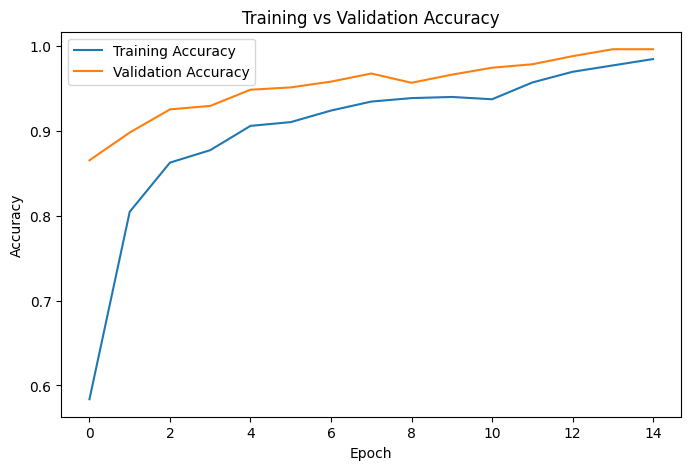

Final Validation Accuracy: 0.9959127902984619


In [ ]:
# Combine training history from both phases and visualize
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(acc, label='Training Accuracy', linewidth=2)
plt.plot(val_acc, label='Validation Accuracy', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.title("Transfer Learning Results - Phase 1 + Phase 2", fontsize=13)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Validation Accuracy: {val_acc[-1]*100:.2f}%")

## Why Transfer Learning Works Better

Transfer learning works effectively because ResNet50 was pre-trained on ImageNet, which contains millions of images. The early convolutional layers learn universal features such as edges, textures, and shapes, which are useful across many visual tasks. By freezing these layers and only training a small classification head, the model adapts quickly to the plant disease dataset. Fine-tuning the deeper layers further improves performance by slightly adjusting high-level features to better match plant disease patterns. Training from scratch would require significantly more data and time, and would likely overfit on this small dataset.